<a href="https://colab.research.google.com/github/Lambru99/CPSProject2/blob/main/cyber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CPS Second Project - Anomaly Detection System**
## Ludovico Latini, Leonardo Cipolletta

Since DAICS is a non-open source model, we tried to create a similar model based on what is written in the paper.
Specifically, we implemented an unsupervised model to perform anomaly detection with a modular architecture to fit large ICSs.
Just like the architecture of DAICS, the key components of the proposed ADS are a two-branch neural network, in which a wide branch is designed to store existing relationships between input features, while a deep branch generalizes the model to unknown relationships (second section). We also implemented an automatic threshold adjustment technique that dynamically adjusts the detection threshold based on the prediction error observed on the live ICS, as also proposed in the paper.
After analyzing the model just described, however, we decided to also explore a supervised approach using LSTM neural networks and then compare the results.
We will then see how, with LSTMs, we were able to obtain a more robust and accurate model for anomaly detection in the context of the SWaT dataset.

About the dataset:
The SWaT dataset is a detailed and realistic dataset representing the operation of a water treatment system.
The dataset provides a comprehensive overview of the day-to-day operations of a water treatment plant consisting of a wide range of variables, including water flows, pressures, temperatures, and other quantities.
Specifically, here are the features of the dataset:
* 11 days of continuous operation: 7 under normal operating conditions and 4 days with attack scenarios.
* Collected network traffic and all values obtained from all 51 sensors and actuators
* Data labeled according to normal and abnormal behavior

We changed the dataset during the course of the project. SWAT had among its data for 1,000,000,000 rows of which about 95% referred to normal situations and 5% to actual attacks, this led the model to have a very high accuracy due to the fact that classifying everything as normal 95% of the time the classification was right. Therefore, in order to have a fairer representation of attacks and normal situations, 800,000 rows were eliminated, resulting in a ratio of about 65% and 35% between attacks and normal behavior.

The columns deleted are:

* The "Normal/Attack" column, which contained the input datai labels.
* The "Timestamp" column containing a printout of the time and day of the detection were removed from the dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Flatten, Reshape, Concatenate
import numpy as np

# Implementation of an Autoencoder as DAICS

In [ ]:
# Dataset initialization and manipulation
file_path = "/content/drive/MyDrive/cyber/definitivo2.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
df['Normal/Attack'] = df['Normal/Attack'].map({'Normal': 0, 'Attack': 1})
df = df.drop(columns=['Timestamp'])
df.dropna(inplace=True)
X = df.drop(columns=['Normal/Attack'])
y = df['Normal/Attack']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model

We try to implement an autencoder similar to DAICS as described in the paper:
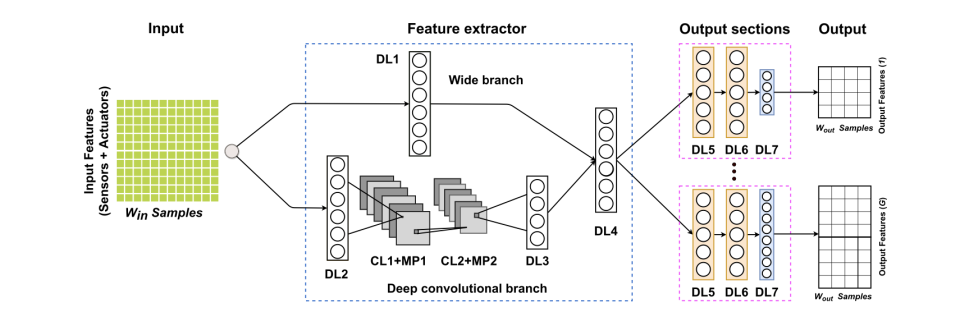

In [ ]:
# Definition of the autoencoder model
def create_wide_deep_autoencoder(input_shape):
    wide_input = Input(shape=input_shape)
    wide_conv1 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(wide_input)
    wide_conv2 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(wide_conv1)
    wide_pooling = MaxPooling1D(pool_size=2)(wide_conv2)
    wide_flatten = Flatten()(wide_pooling)
    wide_dense = Dense(128, activation='relu')(wide_flatten)
    deep_input = Input(shape=input_shape)
    deep_conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(deep_input)
    deep_conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(deep_conv1)
    deep_pooling = MaxPooling1D(pool_size=2)(deep_conv2)
    deep_flatten = Flatten()(deep_pooling)
    deep_dense = Dense(128, activation='relu')(deep_flatten)
    merged = Concatenate()([wide_dense, deep_dense])
    encoder_output = Dense(64, activation='relu')(merged)
    decoder_output = Dense(128, activation='relu')(encoder_output)
    decoder_output = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(decoder_output)
    decoder_output = Reshape(input_shape)(decoder_output)
    autoencoder = Model(inputs=[wide_input, deep_input], outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [ ]:
# Traning of the model with the dataset pre-elaborated
input_shape = X_train_reshaped.shape[1:]
autoencoder_model = create_wide_deep_autoencoder(input_shape)
autoencoder_history=autoencoder_model.fit([X_train_reshaped, X_train_reshaped], X_train_reshaped, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
2625/2625 [==============================] - 22s 6ms/step - loss: 0.6481 - val_loss: 0.6261
Epoch 2/10
2625/2625 [==============================] - 17s 6ms/step - loss: 0.6408 - val_loss: 0.6257
Epoch 3/10
2625/2625 [==============================] - 17s 7ms/step - loss: 0.6406 - val_loss: 0.6255
Epoch 4/10
2625/2625 [==============================] - 18s 7ms/step - loss: 0.6406 - val_loss: 0.6256
Epoch 5/10
2625/2625 [==============================] - 17s 6ms/step - loss: 0.6404 - val_loss: 0.6253
Epoch 6/10
2625/2625 [==============================] - 17s 6ms/step - loss: 0.6405 - val_loss: 0.6253
Epoch 7/10
2625/2625 [==============================] - 17s 7ms/step - loss: 0.6403 - val_loss: 0.6253
Epoch 8/10
2625/2625 [==============================] - 17s 6ms/step - loss: 0.6403 - val_loss: 0.6252
Epoch 9/10
2625/2625 [==============================] - 18s 7ms/step - loss: 0.6402 - val_loss: 0.6251
Epoch 10/10
2625/2625 [==============================] - 24s 9ms/step - l

As we can see from the evaluation method the test evaluation in high.

In [ ]:
# Evaluation of the model
evaluation = autoencoder_model.evaluate([X_test_reshaped, X_test_reshaped], X_test_reshaped)
print("Loss sul set di test:", evaluation)

2813/2813 [==============================] - 9s 3ms/step - loss: 0.6683
Loss sul set di test: 0.6683057546615601


In [ ]:
# Automatic selection of the optimal threshold value for the model generalization
reconstructions = autoencoder_model.predict([X_test_reshaped, X_test_reshaped])
max_reconstruction_error = np.max(np.abs(X_test_reshaped - reconstructions), axis=(1, 2))
std_reconstruction_error = np.std(max_reconstruction_error)
threshold_multiplier = 1
threshold = std_reconstruction_error * threshold_multiplier
predicted_attacks = max_reconstruction_error > threshold
accuracy_attack = (predicted_attacks[y_test == 1] == 1).mean()
accuracy_normal = (predicted_attacks[y_test == 0] == 0).mean()
total_accuracy = (accuracy_attack + accuracy_normal) / 2
print("Standard Deviation of Reconstruction Error:", std_reconstruction_error)
print("Automatically selected Threshold:", threshold)
print("Accuracy for attacks:", accuracy_attack)
print("Accuracy for normal data:", accuracy_normal)
print("Total Accuracy:", total_accuracy)

2813/2813 [==============================] - 7s 2ms/step
Standard Deviation of Reconstruction Error: 2.384369677261787
Automatically selected Threshold: 2.384369677261787
Accuracy for attacks: 0.809320598794283
Accuracy for normal data: 0.8155827584831931
Total Accuracy: 0.812451678638738


## Analysis

From the analyses performed, the autoeconder model has an accuracy of 80% with a Threshold of 2.38. As we can see from the confusion matrix, although for more than 50% the model generalizes the input well, the cases where there are false positives and false negatives are many. Generally it would be preferable if you have labels not to use a model like this but prefer a supervised model like the following.

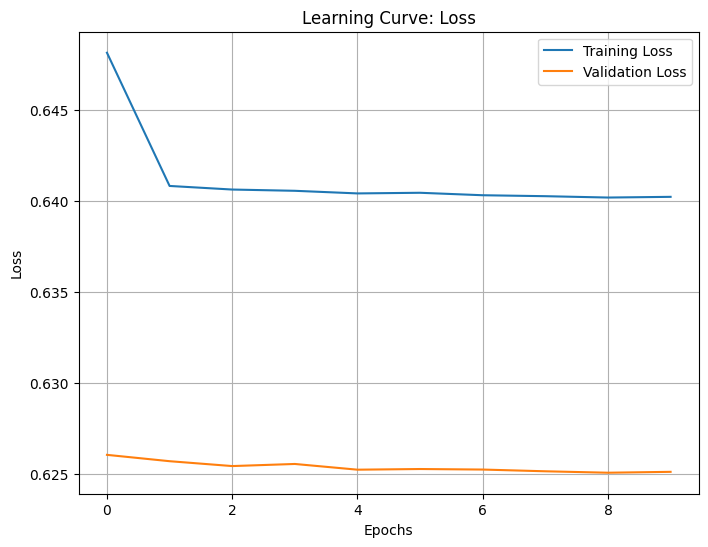

In [ ]:
# Plot of the Learning cirve about the loss of the model
plt.figure(figsize=(8, 6))
plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.plot(autoencoder_history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

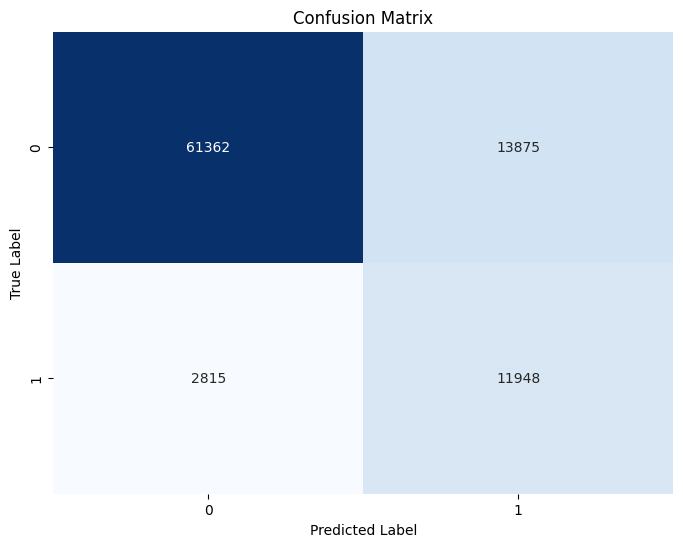

In [ ]:
# Plot of the confusion matrix
cm = confusion_matrix(y_test, predicted_attacks)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

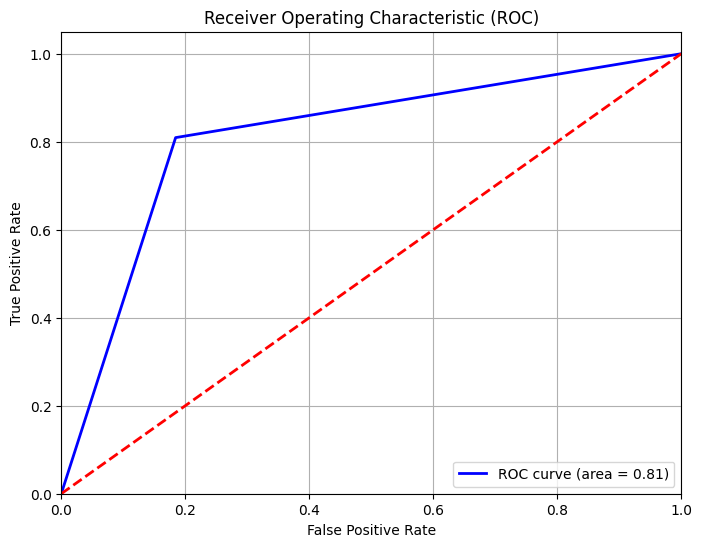

In [ ]:
# Plot of the ROC curves
fpr, tpr, thresholds = roc_curve(y_test, predicted_attacks)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

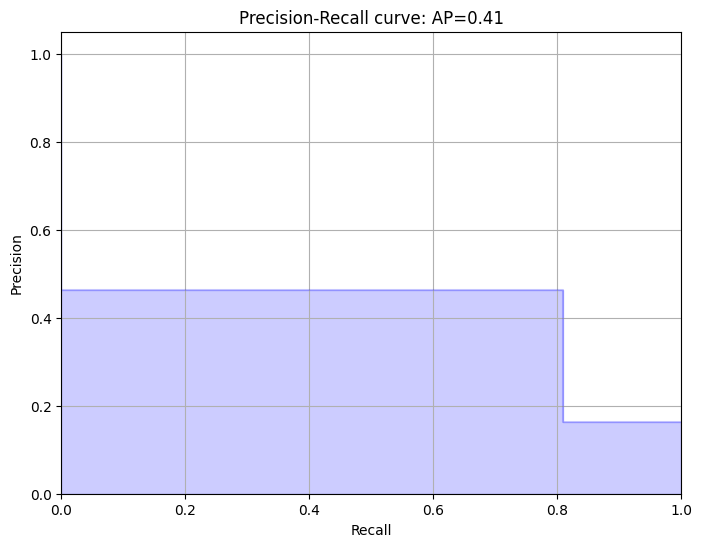

In [ ]:
# Plot of the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, predicted_attacks)
average_precision = average_precision_score(y_test, predicted_attacks)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.grid(True)
plt.show()

# Supervised Model (LSTM)

## Model

The choice of a supervised model was originally intended because of the nature of the data in the SWAT dataset, which contained already written lable "Normal" and "Attack." The ability of recurrent neural networks (RNNs), such as LSTMs, to process data sequences and recognize complex patterns over time.
In the context of the SWaT dataset, temporal information is crucial for identifying anomalous behaviors. LSTMs are particularly well suited to capture these temporal relationships because they maintain a long-term memory of information passed through their gating mechanisms.
In the proposed model, we used two LSTM layers followed by dropout layers to reduce the risk of overfitting. The dropouts help to regularize the model, preventing it from overspecializing on the training data and improving its generalization ability.
Finally, the output layer is a single neuron with a sigmoid activation function, which produces a binary prediction (abnormal or normal) based on the temporal information processed by the model.

In [ ]:
# Defining of the model
def create_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Model and test accuracy and loss
input_shape = (X_train.shape[1], 1)
model = create_lstm_model(input_shape)
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
1313/1313 [==============================] - 28s 12ms/step - loss: 0.1993 - accuracy: 0.9493 - val_loss: 0.1695 - val_accuracy: 0.9582
Epoch 2/10
1313/1313 [==============================] - 14s 11ms/step - loss: 0.1727 - accuracy: 0.9575 - val_loss: 0.1993 - val_accuracy: 0.9479
Epoch 3/10
1313/1313 [==============================] - 13s 10ms/step - loss: 0.1643 - accuracy: 0.9554 - val_loss: 0.1095 - val_accuracy: 0.9666
Epoch 4/10
1313/1313 [==============================] - 14s 11ms/step - loss: 0.0993 - accuracy: 0.9713 - val_loss: 0.0863 - val_accuracy: 0.9770
Epoch 5/10
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0843 - accuracy: 0.9775 - val_loss: 0.1008 - val_accuracy: 0.9747
Epoch 6/10
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0726 - accuracy: 0.9811 - val_loss: 0.0667 - val_accuracy: 0.


## Analysis




Analyzing the model with the following methods what emerges in all cases is that the LSTM model succeeds in generalizing the input test data very well, managing to arrive at a 98% with a threshold of 0.7.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
# Automatic optimal threshold value for the model
y_pred = model.predict(X_test)
std_error = np.std(y_pred)
std_error = np.std(y_pred)
threshold = 1 * std_error
y_pred_anomalies = (y_pred > threshold).astype(int)
accuracy = (y_pred_anomalies.flatten() == y_test.values).mean()
print("Threshold:", threshold)
print("Accuracy:", accuracy)

2813/2813 [==============================] - 11s 4ms/step
Threshold: 0.7087888717651367
Accuracy: 0.9870111111111111


### Classification Report


**Precision**: Represents the proportion of instances classified as positive that are actually positive. In other words, it is the model's ability to not mislabel negative instances as positive. For class 0 (non-anomaly), precision is 99%, meaning that 1% of the instances classified as non-anomalies are actually anomalies. For class 1 (anomaly), precision is 99%, indicating that 1% of instances classified as anomalies might be false positives.

**Recall**: Represents the proportion of total positive instances that were correctly identified by the model. In other words, it is the model's ability to find all positive instances. For class 0, recall is 100%, indicating that all non-anomaly instances were correctly identified. For class 1, recall is 93%, meaning that 7% of anomaly instances might not have been detected by the model.

**F1-score**: It is a weighted average of precision and recall. It represents the balance between precision and recall. A high F1-score indicates a good balance between precision and recall.

**Support**: Represents the number of instances in each class in the test dataset.

**Accuracy**: Represents the proportion of correct predictions out of the total predictions made by the model. In your case, accuracy is 100%, meaning all predictions made by the model are correct in the test dataset.

In [ ]:
print(classification_report(y_test, y_pred_anomalies))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     75237
           1       0.99      0.93      0.96     14763

    accuracy                           0.99     90000
   macro avg       0.99      0.96      0.98     90000
weighted avg       0.99      0.99      0.99     90000



### Learning Curves
The learning curve can provide valuable insights into the performance of a machine learning model during training.
As we can see from these two learning curves that analyze both loss and accuracy, the model seems to be learning effectively and generalizing well to unseen data.

* Both the training and validation loss curves show a clear downward trend, indicating that the model is consistently improving its ability to correctly classify instances.
* The gap between the training and validation curves remains small throughout the training process, suggesting that the model is not significantly overfitting the training data. This is crucial for good generalization to unseen data.
* Both training and validation accuracy curves show an upward trend, reaching high final values. This implies that the model is correctly classifying both training and unseen data with a high degree of accuracy.

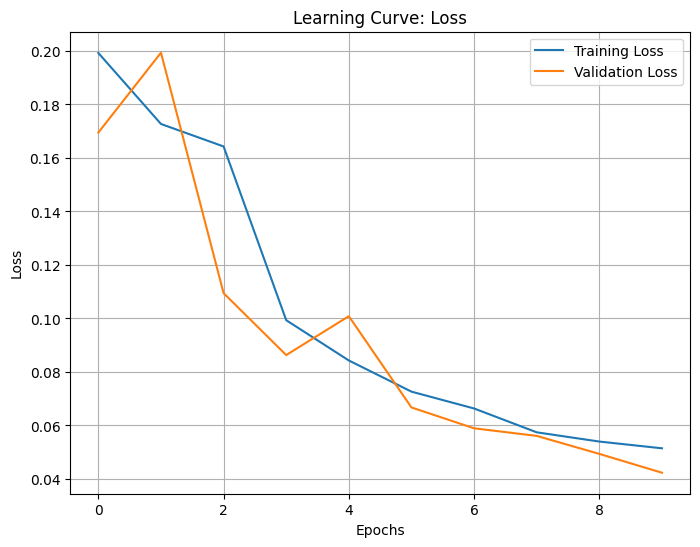

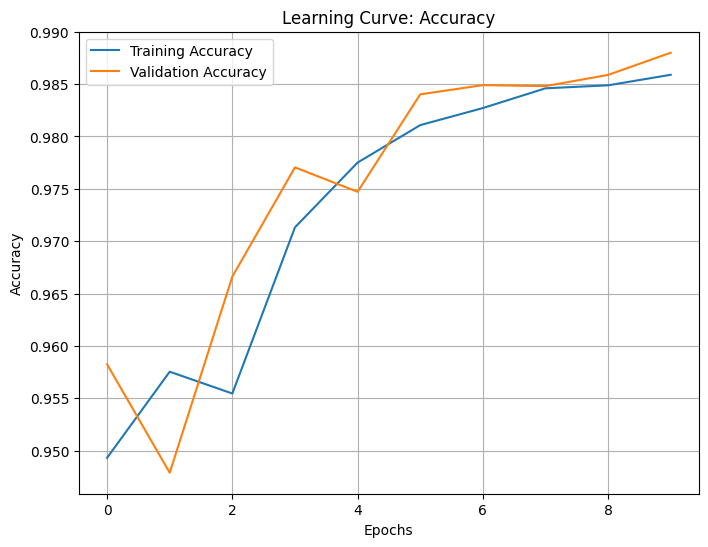

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Confusion Matrix

The confusion matrix helps visualize true positives, true negatives, false positives, and false negatives.

As we already discussed for the curves, this confusion matrix further strengthens the case that the model is a highly effective anomaly detector.

* Just like the low training and validation loss in the curves, the TPR of 0.98 in the confusion matrix confirms the model's ability to correctly identify real attacks. This signifies minimal instances slipping through the cracks.
* The TNR of 1.00 echoes the small gap between curves, indicating excellent generalization. The model rarely misclassifies normal instances as attacks, minimizing false alarms.
* The precision of 0.98 for attacks reiterates the curves' suggestion of minimal overfitting. The model focuses on true positives, reducing noise and false positives.
* The recall of 0.98 for attacks aligns with the high validation accuracy, reflecting the model's ability to capture most attacks. Missed attacks are rare.

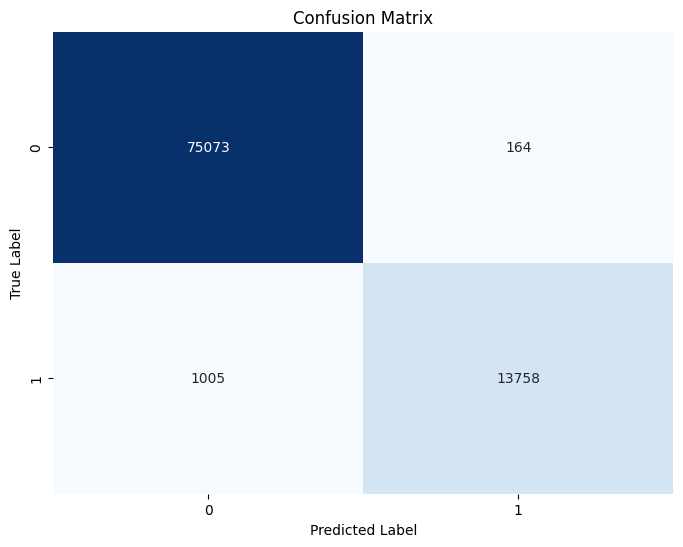

In [ ]:
cm = confusion_matrix(y_test, y_pred_anomalies)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### ROC Curve

The ROC curve illustrates the trade-off between sensitivity and specificity at various threshold settings. Based on the combination of all the analyses, it's likely that your model slightly prioritizes sensitivity, especially at stricter thresholds. However, it maintains a good overall balance between sensitivity and specificity across various thresholds.



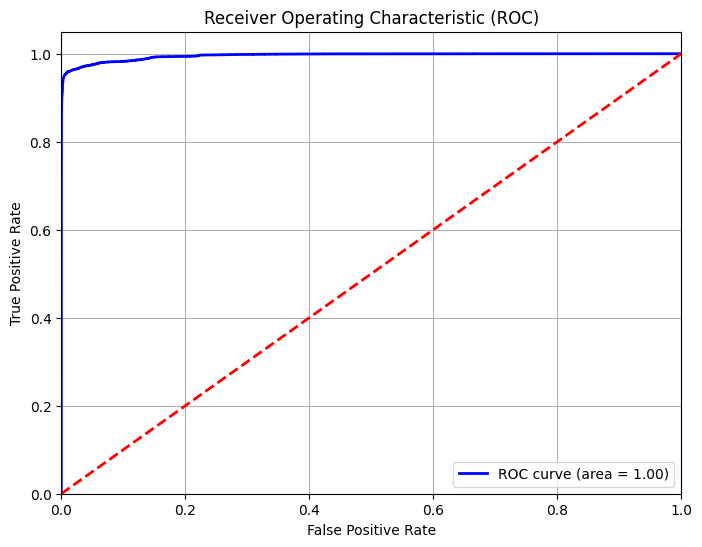

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Precision-Recall curve

The precision-recall curve illustrates the trade-off between precision and recall. As we can see the curve starts very close to the top (representing perfect precision) and gradually decreases as recall increases. This means the model can achieve very high precision even when only a small portion of actual attacks are identified.

The decrease in precision as recall increases is relatively slow, indicating that the model maintains good precision even as it identifies more attacks. This is a positive sign, as it suggests the model does not generate a large number of false positives when trying to catch more attacks.





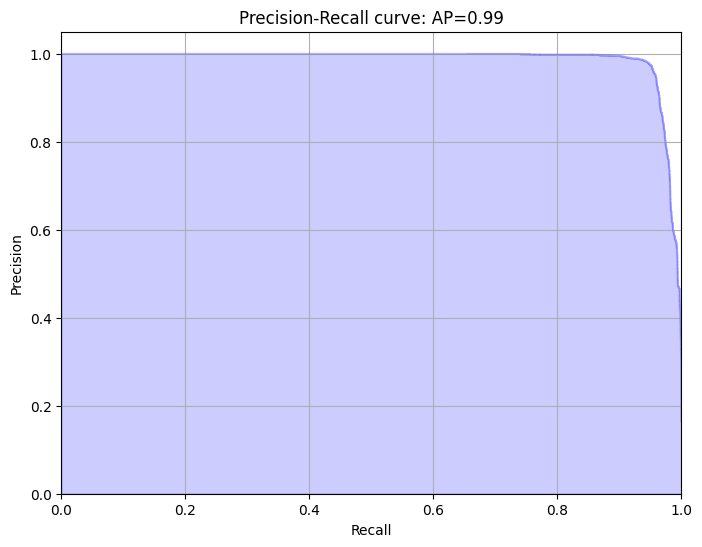

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.grid(True)
plt.show()


### histogram of predicted anomaly scores

The histogram of predicted anomaly scores shows the distribution of anomaly scores across the test set. Basing on this histogram it seems like this model's predictions are indeed slightly skewed towards the attack class (higher values), consistent with what I mentioned earlier. Here's a more detailed analysis:

**Observations**:

* **Shape**: The histogram has a relatively smooth, unimodal distribution, as expected for a well-performing model.
* **Distribution**: The peak of the distribution leans slightly towards the right side, indicating that a larger portion of predictions fall into higher values, which represent predicted attacks. This aligns with the idea that the model prioritizes sensitivity to some extent, aiming to catch most attacks even if it means some false positives.
* **Outliers**: There are a few outliers on both ends of the histogram, but they are relatively infrequent. This suggests that most predictions are confident (closer to either 0 or 1), while a small number fall into the less confident range.

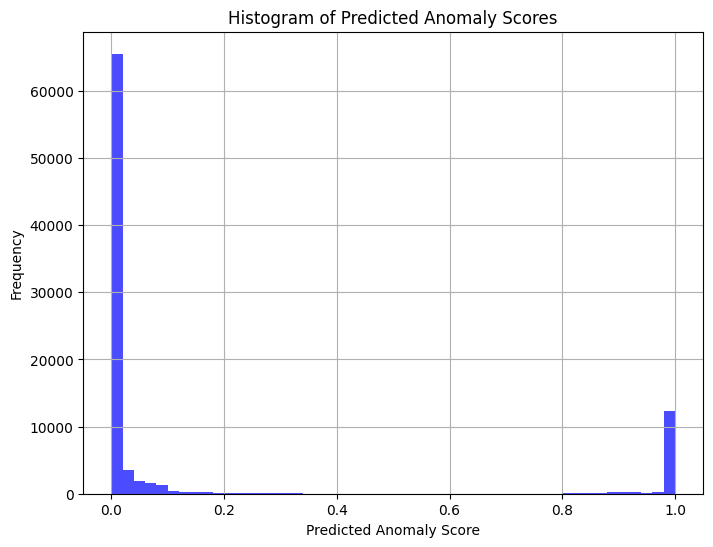

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=50, color='blue', alpha=0.7)
plt.xlabel('Predicted Anomaly Score')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Anomaly Scores')
plt.grid(True)
plt.show()

## Attack model

In order to test the attack resistance of the LSTM model, we implemented 3 attacks: Adversarial Attacks, Data Poisoning and Synthetic Attacks.
From what emerges from the results, the model manages to resist attacks very well, presenting an accuracy that was 86% at worst.

### Synthetic Attack

With this attack, an attacker modifies the training data by introducing malicious data points to influence the behavior of the model.

In [ ]:
def add_outliers(X_test, outlier_ratio=1):
    num_outliers = int(len(X_test) * outlier_ratio)
    indices = np.random.choice(len(X_test), num_outliers, replace=False)
    X_test_outliers = X_test.copy()
    for idx in indices:
        feature_idx = np.random.randint(0, X_test.shape[1])
        X_test_outliers[idx, feature_idx] *= np.random.uniform(5, 10)
    return X_test_outliers

In [ ]:
X_test_attacked = add_outliers(X_test)
test_loss_attacked, test_accuracy_attacked = model.evaluate(X_test_attacked, y_test)
print("Test Accuracy on Attacked Test Set:", test_accuracy_attacked)

2813/2813 [==============================] - 13s 5ms/step - loss: 0.4672 - accuracy: 0.8639
Test Accuracy on Attacked Test Set: 0.8638555407524109


### Data poisoning

Attackers inject malicious data into the training dataset to manipulate the model's behavior.

In [ ]:
def add_malicious_instances(X_train, y_train, malicious_ratio=1):
    num_malicious = int(len(X_train) * malicious_ratio)
    malicious_instances = np.random.rand(num_malicious, X_train.shape[1])
    malicious_labels = np.ones(num_malicious)
    X_train_malicious = np.concatenate([X_train, malicious_instances])
    y_train_malicious = np.concatenate([y_train, malicious_labels])
    return X_train_malicious, y_train_malicious

In [ ]:
X_train_poisoned, y_train_poisoned = add_malicious_instances(X_train, y_train)
poisoned_model = create_lstm_model(input_shape)
history_poisoned = poisoned_model.fit(X_train_poisoned, y_train_poisoned, epochs=1, batch_size=128, validation_split=0.2)
test_loss_poisoned, test_accuracy_poisoned = poisoned_model.evaluate(X_test, y_test)
print("Test Accuracy of Poisoned Model on Original Test Set:", test_accuracy_poisoned)


2813/2813 [==============================] - 13s 5ms/step - loss: 0.1901 - accuracy: 0.9437
Test Accuracy of Poisoned Model on Original Test Set: 0.9437111020088196


### Adversarial attacks

These involve crafting specific inputs that intentionally trigger false positives or negatives. In the context of ICSs, this could involve manipulating sensor data to appear normal while hiding malicious activity.

In [ ]:
def fgsm_attack_numpy(model, X, y, epsilon=0.5):
    gradient = compute_gradient(model, X, y)
    sign_gradient = np.sign(gradient)
    perturbation = epsilon * sign_gradient
    adversarial_X = X + perturbation.T
    return adversarial_X
def compute_gradient(model, X, y):
    logits = model.predict(X)
    y_array = np.array(y).reshape(-1, 1)
    error = logits - y_array
    gradient = X.T @ error / len(X)
    return gradient

In [ ]:
epsilon = 0.1
X_test_adv_numpy = fgsm_attack_numpy(model, X_test, np.array(y_test), epsilon)
test_loss_adv_numpy, test_accuracy_adv_numpy = model.evaluate(X_test_adv_numpy, y_test)
print("Test Accuracy on Adversarial Examples (NumPy):", test_accuracy_adv_numpy)


2813/2813 [==============================] - 14s 5ms/step - loss: 0.0777 - accuracy: 0.9803
Test Accuracy on Adversarial Examples (NumPy): 0.9802777767181396


# Conclusion

In conclusion, we reiterate that if you have labels referring to the input data, it is preferable to use a supervised model that can ensure a more correct generalization of cases. In particular, in the case of Anomaly detection, the importance of having excellent accuracy is not as essential as the importance of not having false negatives. Even judging the models by this parameter, however, the best remains supervised LSTM which guarantees fewer attacks are classified as normal behavior.